In [3]:
!pip install opencv-python
!pip install scenedetect

In [1]:
video_path = "/Users/ducle/mSATA/videos/Tiêu điểm_ SPF chỉ là con số  Cảnh báo từ những vụ bê bối kem chống nắng _ VTV24.mp4"
video_path = r"D:\source_AI\scene\scene_grouping\Các địa phương triển khai biện pháp ứng phó COVID-19 _ VTV24.mp4"

In [2]:
from scenedetect import detect, ContentDetector
import cv2
def detect_scenes(video_path):
    scene_list = detect(video_path, ContentDetector())
    info = {}
    # get total number of frames
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # get duration of video
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    duration = total_frames / fps
    info['total_frames'] = total_frames
    info['duration'] = duration
    # get scene list
    frame_list = []
    time_list = []
    for i, scene in enumerate(scene_list):
        start_frame = scene[0].get_frames()
        end_frame = scene[1].get_frames()
        start_time = scene[0].get_timecode()
        end_time = scene[1].get_timecode()
        frame_list.append((start_frame, end_frame))
        time_list.append((start_time, end_time))
    info['frame_list'] = frame_list
    info['time_list'] = time_list
    
    return info

c:\ProgramData\anaconda3\envs\stt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
frame_list = detect_scenes(video_path)
mid_frames = [(start + end) // 2 for start, end in frame_list['frame_list']]

In [4]:
# split into clip
import cv2 
import os
scene_path = "scene"
if not os.path.exists(scene_path):
    os.makedirs(scene_path)

num_clips = len(frame_list['frame_list'])
for i in range(num_clips):
    start_frame, end_frame = frame_list['frame_list'][i]
    mid_frame = mid_frames[i]
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    out = cv2.VideoWriter(f"{scene_path}/clip_{i}.mp4", 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          30, (int(cap.get(3)), int(cap.get(4))))
    
    for frame_num in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
    
    out.release()
    cap.release()


In [5]:
!pip install transformers

In [6]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np

# Load the CLIP model and processor once
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

def encode_frame_to_vector(frame):
    """
    Encodes an image frame into a vector using Hugging Face's CLIP model.

    Args:
        frame (PIL.Image.Image or np.ndarray): The input image frame.

    Returns:
        torch.Tensor: The image embedding vector (shape: [1, embedding_dim]).
    """
    # Convert NumPy array to PIL Image if needed
    if isinstance(frame, np.ndarray):
        frame = Image.fromarray(frame)

    # Preprocess the frame
    inputs = clip_processor(images=frame, return_tensors="pt")

    # Get image embedding
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)

    # Normalize the vector
    image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)

    return image_features


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
features = []
import cv2
def extract_frame(video_path, frame_number):
    """
    Extracts a specific frame from a video file.

    Args:
        video_path (str): Path to the video file.
        frame_number (int): The frame number to extract.

    Returns:
        np.ndarray: The extracted frame as a NumPy array.
    """
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        raise ValueError(f"Could not read frame {frame_number} from video.")
    
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
import time 
start_time = time.time()
# Extract mid frames and encode them to vectors
for frame_number in mid_frames:
    frame = extract_frame(video_path, frame_number)
    feature = encode_frame_to_vector(frame)
    features.append(feature)
print(f"Time taken to process {len(mid_frames)} frames: {time.time() - start_time:.2f} seconds")


Time taken to process 26 frames: 10.41 seconds


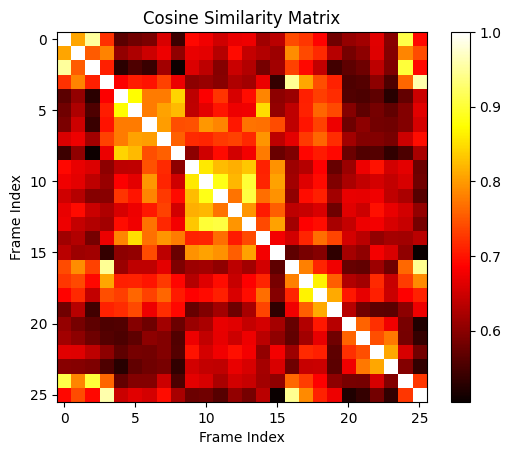

In [8]:
import matplotlib.pyplot as plt

# show the correlation between the features by cosine similarity
def cosine_similarity(a, b):
    """
    Computes the cosine similarity between two vectors.

    Args:
        a (torch.Tensor): First vector.
        b (torch.Tensor): Second vector.

    Returns:
        float: Cosine similarity value.
    """
    return torch.nn.functional.cosine_similarity(a, b).item()

def plot_similarity_matrix(features):
    """
    Plots a similarity matrix for the given features.

    Args:
        features (list of torch.Tensor): List of feature vectors.
    """
    num_features = len(features)
    similarity_matrix = np.zeros((num_features, num_features))

    for i in range(num_features):
        for j in range(num_features):
            similarity_matrix[i, j] = cosine_similarity(features[i], features[j])

    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Cosine Similarity Matrix')
    plt.xlabel('Frame Index')
    plt.ylabel('Frame Index')
    plt.show()
    return similarity_matrix
similarity_matrix = plot_similarity_matrix(features)

In [10]:
def convert_timecode_to_seconds(timecode):
    """
    Converts a timecode string to seconds.

    Args:
        timecode (str): Timecode in the format 'HH:MM:SS.mmm'.

    Returns:
        float: Time in seconds.
    """
    parts = timecode.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds = float(parts[2])
    
    return hours * 3600 + minutes * 60 + seconds

In [11]:
time_list = frame_list['time_list']

# Convert time_list to seconds
time_list_seconds = [(convert_timecode_to_seconds(start), convert_timecode_to_seconds(end)) for start, end in time_list]
# Create a DataFrame to store the results
time_list_seconds[0:5]  # Display the first 5 time intervals for brevity

[(0.0, 6.28), (6.28, 14.04), (14.04, 20.24), (20.24, 29.64), (29.64, 31.16)]

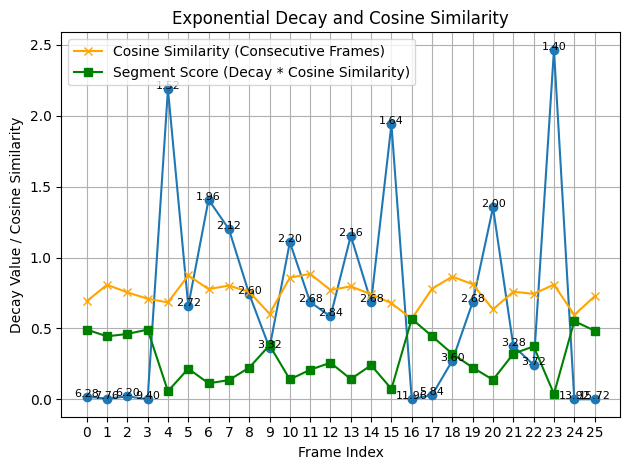

Text(0, 0.5, 'Decay Value')

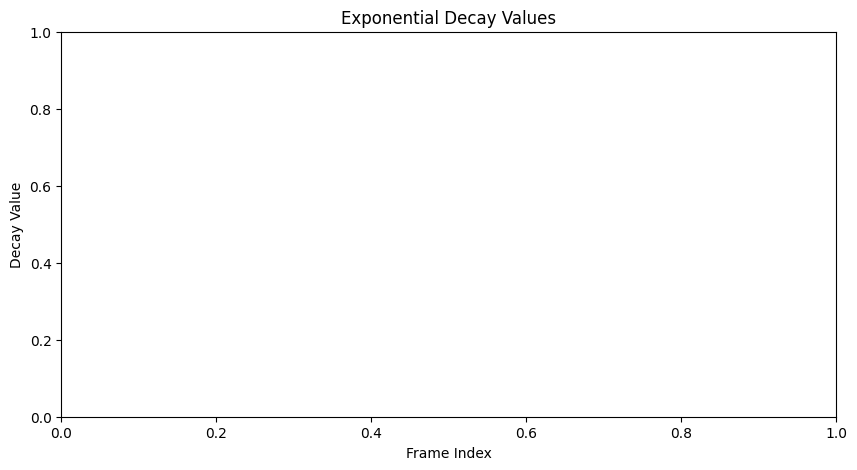

In [13]:
# compute a eˆ(-x), x is the time difference between two frames
def compute_exponential_decay(time_list):
    """
    Computes an exponential decay based on the time differences between frames.

    Args:
        features (list of torch.Tensor): List of feature vectors.
        time_list (list of tuples): List of tuples containing start and end times for each frame.

    Returns:
        list: Exponential decay values for each frame.
    """
    decay_values = []
    for i in range(len(time_list) ):
        time_diff = (time_list[i ][1] - time_list[i][0])  # end - start
        decay_value = float(np.exp(-time_diff)) * 10 
        decay_values.append(decay_value)
    return decay_values
decay_values = compute_exponential_decay(time_list_seconds)
# Plot the decay values
plt.plot(decay_values, marker='o')
# plot the time above the decay values
for i, decay_value in enumerate(decay_values):
    plt.text(i, decay_value, f"{time_list_seconds[i][1]-time_list_seconds[i][0]:.2f}", fontsize=8, ha='center')
plt.title('Exponential Decay Values Over Time')
# plot similarity matrix
sim_consecutive = []
for i in range(len(features)):
    sim_consecutive.append(cosine_similarity(features[i], features[i - 1]))
plt.plot(sim_consecutive, marker='x', color='orange', label='Cosine Similarity (Consecutive Frames)')
plt.legend()
plt.xlabel('Frame Index')
plt.ylabel('Decay Value / Cosine Similarity')
plt.xticks(range(len(decay_values)), range(len(decay_values)))
# plot the segment score:= decay_value * cosine_similarity 
segment_scores = [decay_values[i] + sim_consecutive[i] for i in range(len(sim_consecutive))]
# apply e^(-x) to the segment scores
segment_scores = [np.exp(-score) for score in segment_scores]
plt.plot(segment_scores, marker='s', color='green', label='Segment Score (Decay * Cosine Similarity)')
plt.legend()
plt.title('Exponential Decay and Cosine Similarity')
plt.grid()
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 5))
plt.title('Exponential Decay Values')
plt.xlabel('Frame Index')
plt.ylabel('Decay Value')

In [51]:
# [(end-start) for start, end in time_list_seconds]

In [15]:
# group  consecutive frames with cosine similarity > 0.8
import numpy as np
def group_similar_frames(features, threshold=0.8, max_gap=1):
    
    groups = list()
    c_group = list()
    idx = -1
    while(idx<len(features)-1):
        idx+=1

        if len(c_group)==0:
            c_group.append(idx)
            continue 
        # sim = np.dot(features[idx], features[idx-1].reshape(-1))
        sim =  features[idx]
        if sim>=threshold:
            c_group.append(idx)
            continue 
        else:
            flag = False
            for i in range(max_gap):
                for j in c_group:
                    if not i+idx>=len(features): 
                        # _sim = np.dot(features[j],features[idx+i].reshape(-1))
                        _sim =  features[idx]
                        
                        if _sim>=threshold:
                            flag = True 
                            for ii in range(i):
                                idx+=ii
                                c_group.append(idx)
                            break 
                
                if flag:
                    break 
            if not flag:
                # print(groups)
                groups.append(c_group)
                c_group = list()
                c_group.append(idx)
    return groups
features = segment_scores
groups = group_similar_frames(features, threshold=0.25, max_gap=1) 
groups                  
            
            



[[0, 1, 2, 3],
 [4],
 [5],
 [6],
 [7],
 [8, 9],
 [10],
 [11, 12],
 [13],
 [14],
 [15, 16, 17, 18],
 [19],
 [20, 21, 22]]

In [32]:



from ollama import Client 

device = "cuda:1"
client_1 = Client(
    host='http://localhost:11434',
    headers={'x-some-header': 'some-value'}, timeout=15,
)


def gemma3_captioning(client, img_path):
  
    prompt = 'Describe this extracted frame, no more than 3 words, no redundant words:'
    try:
        res = client.chat(
            model="gemma3:4b",
            messages=[
                {
                    'role': 'user',
                    'content': prompt,
                    'images': [img_path]
                }
            ],
   
        )
    except Exception as e:
        print(e)
        return None
    return res['message']['content']

def gemma3_summarization(client, text):
    """
    Summarizes the given text using the Gemma3 model.
    
    Args:
        client (Client): Ollama client instance.
        text (str): Text to summarize.
    
    Returns:
        str: Summarized text.
    """
    prompt = 'Summarize this video for better human readable:'
    try:
        res = client.chat(
            model="gemma3:4b",
            messages=[
                {
                    'role': 'user',
                    'content': prompt + '\n' + text
                }
            ],
        )
    except Exception as e:
        print(e)
        return None
    return res['message']['content']

In [33]:
# save frame captions to a image file
import os
import cv2 

cap = cv2.VideoCapture(video_path)
file_path_list = []
def save_frame(frame_number, output_dir):
    """
    Saves a specific frame from the video to an image file.

    Args:
        frame_number (int): The frame number to save.
        output_dir (str): Directory to save the image.
    """
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        file_path = os.path.join(output_dir, f"frame_{frame_number}.jpg")
        cv2.imwrite(file_path, frame)
        return file_path
    else:
        raise ValueError(f"Could not read frame {frame_number} from video.")

for i, frame_number in enumerate(mid_frames):
    output_dir = "frames"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    file_path = save_frame(frame_number, output_dir)
    file_path_list.append(file_path)
    

In [34]:
caption_list = list()
for file_path in file_path_list:
    caption = gemma3_captioning(client_1, file_path)
    if caption:
        print(f"Caption for {file_path}: {caption}")
    else:
        print(f"Failed to get caption for {file_path}")
    caption_list.append(caption)    


Caption for frames\frame_78.jpg: News studio scene
Caption for frames\frame_254.jpg: Woman on screen
Caption for frames\frame_428.jpg: News studio scene
Caption for frames\frame_623.jpg: News presenter, cityscape.
Caption for frames\frame_760.jpg: COVID-19 prevention signs
Caption for frames\frame_813.jpg: COVID-19 prevention signs
Caption for frames\frame_871.jpg: Doctor, medical setting
Caption for frames\frame_922.jpg: Cleaning, disinfection, surface.
Caption for frames\frame_981.jpg: Inpatient information display
Caption for frames\frame_1055.jpg: Healthcare worker support
Caption for frames\frame_1124.jpg: Doctor examining patient
Caption for frames\frame_1185.jpg: Hospital patient care
Caption for frames\frame_1254.jpg: Doctor in PPE
Caption for frames\frame_1317.jpg: Hospital patient scene
Caption for frames\frame_1377.jpg: Empty corridor space.
Caption for frames\frame_1431.jpg: COVID test taken
Caption for frames\frame_1601.jpg: News broadcast scene
Caption for frames\frame_18

In [35]:
# summarize the captions
summary = gemma3_summarization(client_1, '\n'.join(caption_list))
print("Summary of captions:", summary)


Summary of captions: Okay, here's a human-readable summary of the video footage, pieced together to paint a picture of what it likely depicts:

**The video appears to be a news report focusing on the ongoing impact of COVID-19 and related public health measures.**

Here's a breakdown of the scenes:

*   **Initial News Segments:** The video starts with a news studio scene and a news presenter alongside a cityscape, likely setting the stage for a report.
*   **COVID-19 Prevention:** There are several shots of COVID-19 prevention signs, emphasizing the continued need for vigilance.
*   **Healthcare Focus:** The video then shifts to scenes within a medical setting, showing a doctor examining a patient, healthcare workers providing support, and a patient receiving care. A doctor is also seen wearing Personal Protective Equipment (PPE).
*   **Testing & Patient Care:** There's a shot of a COVID test being taken, highlighting testing efforts.
*   **Travel & Public Spaces:** The footage transit

In [37]:
import ollama

# Tạo embedding cho văn bản
embedding = ollama.embed(
    model='bge-m3',
    input='Trí tuệ nhân tạo đang thay đổi thế giới.'
)

print(embedding['embedding'][:10])  # In ra 10 giá trị đầu tiên của vector


ConnectError: [WinError 10049] The requested address is not valid in its context

In [36]:
similar_frame_groups = groups


In [77]:
# group the start and end frames of each group
def group_frame_ranges(groups, frame_list):
    """
    Groups the start and end frames of each group.

    Args:
        groups (list of list): List of groups of similar frames.
        frame_list (list of tuple): List of tuples containing start and end frames.

    Returns:
        list of tuple: List of tuples containing start and end frames for each group.
    """
    grouped_ranges = []
    
    for group in groups:
        if group:
            start_frame = frame_list[group[0]][0]
            end_frame = frame_list[group[-1]][1]
            grouped_ranges.append((start_frame, end_frame))
    
    return grouped_ranges
grouped_ranges = group_frame_ranges(similar_frame_groups, frame_list['frame_list'])
grouped_ranges

[(0, 472),
 (472, 1341),
 (1341, 1472),
 (1472, 1605),
 (1605, 2134),
 (2134, 2716),
 (2716, 3087),
 (3087, 3525),
 (3525, 4051),
 (4051, 4837),
 (4837, 5339),
 (5339, 5716),
 (5716, 6289),
 (6289, 6470),
 (6470, 7228),
 (7228, 7964),
 (7964, 8435),
 (8435, 9525),
 (9525, 9981),
 (9981, 10644),
 (10644, 10924),
 (10924, 11233),
 (11233, 12368),
 (12368, 13060),
 (13060, 13689),
 (13689, 14826),
 (14826, 15025),
 (15025, 15464),
 (15464, 16192),
 (16192, 16372),
 (16372, 16614)]

In [78]:
scene_path = "scene_grouped"
import os
if not os.path.exists(scene_path):
    os.makedirs(scene_path)
# Save the grouped scenes as clips
num_clips = len(grouped_ranges)
for i in range(num_clips):
    start_frame, end_frame = grouped_ranges[i]
    mid_frame = mid_frames[i]
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    out = cv2.VideoWriter(f"{scene_path}/clip_{i}.mp4", 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          30, (int(cap.get(3)), int(cap.get(4))))
    
    for frame_num in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
    
    out.release()
    cap.release()


KeyboardInterrupt: 

In [ ]:
import unicodedata

def remove_vietnamese_accents(text):
    """
    Convert Vietnamese text to unsigned characters by removing accents.

    Args:
        text (str): The input Vietnamese text.

    Returns:
        str: Text with accents removed.
    """
    text = unicodedata.normalize('NFD', text)
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')
    return text

out_video_path = remove_vietnamese_accents(video_path)

In [81]:
import os 
video_name  = os.path.basename(video_path)
video_name

'Tiêu điểm_ SPF chỉ là con số  Cảnh báo từ những vụ bê bối kem chống nắng _ VTV24.mp4'

In [82]:
video_name = video_name.split('.')[0]  # Get the base name without extension
# write to video, denote the start and end frames of each group
def write_grouped_video(video_path, grouped_ranges, output_path):
    """
    Writes a new video file with highlighted groups of frames.

    Args:
        video_path (str): Path to the input video file.
        grouped_ranges (list of tuple): List of tuples containing start and end frames for each group.
        output_path (str): Path to save the output video file.
    """
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        for start, end in grouped_ranges:
            if start <= frame_count <= end:
                cv2.putText(frame, f"Group: {start}-{end}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        for start, end in frame_list['frame_list']:
            if start <= frame_count <= end:
                cv2.putText(frame, f"Original: {start}-{end}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
output_video_path = f"grouped_video_{video_name}.mp4"
write_grouped_video(video_path, grouped_ranges, output_video_path)


In [80]:
# write original video with original start and end frames

def write_original_video(video_path, frame_list, output_path):
    """
    Writes a new video file with original start and end frames highlighted.

    Args:
        video_path (str): Path to the input video file.
        frame_list (list of tuple): List of tuples containing start and end frames.
        output_path (str): Path to save the output video file.
    """
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        for start, end in frame_list['frame_list']:
            if start <= frame_count <= end:
                cv2.putText(frame, f"Original: {start}-{end}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        out.write(frame)
        frame_count += 1

    cap.release()
    out.release()
original_video_path = f"original_video_{video_name}.mp4"
write_original_video(video_path, frame_list, original_video_path)

NameError: name 'video_name' is not defined